- Content (c)
- Style (s)
- Generated (g)


### Visualizing What a deep network is learning
[Zeiler and Fergus, 2013, Visualizing and Understanding Convolutional Networks]

Gist: Pick a unit in layer 1. Find the nine image patches that maximize that unit's activation.

### Cost Function
[Gatys et al., 2015. A neural algorithm of artistic style]
- Use Gradient descent to minimize J(G) = alpha * Jcontent(C, G) + beta* Jstyle(S, G)
- Steps:
    - 1: Initiate G randomly (G: [100 x 100 x 3] matrix)
    - 2: Use gradient descent to minimize J(G)
    - 3: Repeat
#### Content cost:
- Say you use hidden layer *l* to compute content cost
    - Use pre-trained ConvNet (e.g. VGG network)
    - Let a^[l](C) and a^[l](G) be the activation of layer l on the images
    - If a^[l](C) and a^[l](G) are similar, both images have similar content

#### Style cost:
- Take a layer of the network and visualize the different components as described in vid 2. Take correlations between each component (e.g. do vertical lines correspond with orange colors?)


# Current todo's
- Visualize hidden layers for content vs style
- Source / expand description for VGG19
- Compare eager execution vs. fast style transfer
- Texture transfer

# Load images

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [3]:
tf.enable_eager_execution()

In [53]:
def load_img(path_to_img, max_dim = 512):
    """
    purpose: 
        Reshape an input image into dimensions compatible with VGG19 model
    
    details:
        1) Load image
        2) Resize to maximum dimension size
        3) Store image in numpy array
        4) Convert 3D image into 4D via np.expand()
        
    args:
        path_to_img (string)    file location of image
        max_dim     (integer)   maximum dimensions for rescaling large images
        
    rets:
        img         (np array)  rescaled 4D image array
    """
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long

    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    return img


def imshow(img, ax, title=None):
    """
    purpose:
        -Remove 4th dimension from image array, plot via
        matplotlib.pyplot.imshow()
        
    args:
        img    (np array)    4D representation of image
        ax     (plt Axes)    Location of plotted image
        title  (string)      Title for plotted image
    """
    out = np.squeeze(img, axis=0).astype('uint8')
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.imshow(out)
    if title:
        ax.set_title(title)    
        

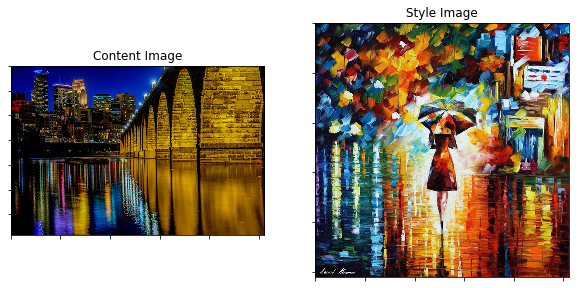

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

content = load_img('data/content/stonearch.jpg').astype('uint8')
style = load_img('data/style/rainPrincess.jpg').astype('uint8')

imshow(content, ax[0], 'Content Image')
imshow(style, ax[1], 'Style Image')
plt.show()

# Preprocess Data

If you've used Photoshop or similar software, you are probably used to the RGB convention of images. The [VGG Networks](https://arxiv.org/pdf/1409.1556.pdf) works with BGR instead. It also preprocesses the images by normalizing BGR through subtracting [103.939, 116.779, 123.68]

In [56]:
def load_and_process_img(path_to_img):
    """
    purpose:
        apply vgg19 preprocessing to image
    args:
        path_to_img   (string)   file location of image
    rets:
        img           (np array) 4D representation of image
    """
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    """
    purpose:
        reverse vgg19 preprocessing
    details:
        -add [103.939, 116.779, 123.68] to respective BGR vectors
        -remove 4th dimension from image
    args:
        processed_img (4D np array)
    rets:
        img (3D np array)
    """
    img = processed_img.copy()
    if len(img.shape) == 4:
        img = np.squeeze(img, 0)
    else:
        raise ValueError("Invalid input to deprocessing image")

    img[:, :, 0] += 103.939 # Blue
    img[:, :, 1] += 116.779 # Green
    img[:, :, 2] += 123.68  # Red
    img = img[:, :, ::-1]   # 4D to 3D

    img = np.clip(img, 0, 255).astype('uint8')
    return img

todo - visualize content layers & style layers

# Build Model

In [59]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [60]:
def get_model():
    """ Creates our model with access to intermediate layers. 

    This function will load the VGG19 model and access the intermediate layers. 
    These layers will then be used to create a new model that will take input image
    and return the outputs from these intermediate layers from the VGG model. 

    Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
    """
    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    # Build model 
    return models.Model(vgg.input, model_outputs)

In [61]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [62]:
def get_feature_representations(model, content_path, style_path):
    """Helper function to compute our content and style feature representations.

    This function will simply load and preprocess both the content and style 
    images from their path. Then it will feed them through the network to obtain
    the outputs of the intermediate layers. 

    Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image

    Returns:
    returns the style features and the content features. 
    """
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)


    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

# Viusalize Content Features
- todo: expand on content dimensions
- 

In [68]:
model = get_model() 
for layer in model.layers:
    layer.trainable = False

# Get the style and content feature representations (from our specified intermediate layers) 
style_features, content_features = get_feature_representations(model, content_path, style_path)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

In [137]:
style_features[0].numpy().shape

(512, 511, 64)

In [103]:
# Extracts the outputs of all layers
layer_outputs = [layer.output for layer in model.layers]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [105]:
activations = activation_model.predict(content)

In [122]:
content_activation = activations[18]
print(content_activation.shape)

(1, 21, 32, 512)


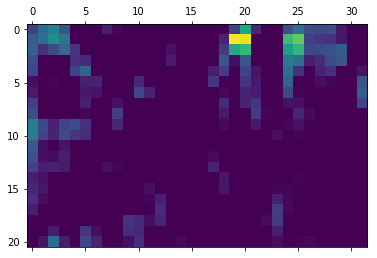

In [135]:
plt.matshow(content_activation[0,:,:,511])

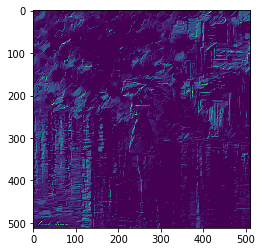

In [145]:
plt.imshow(style_features[0].numpy()[:,:,20])

In [146]:
content_features[0].numpy().shape

(21, 32, 512)

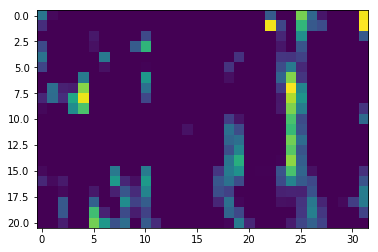

In [156]:
plt.imshow(content_features[0].numpy()[:,:,10])

In [117]:
model.get_layer('block5_conv2')

In [119]:
len(model.layers)

19

In [120]:
len(activations)

19

In [63]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the loss total loss.

    Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.

    Returns:
    returns the total loss, style loss, content loss, and total variational loss
    """
    style_weight, content_weight = loss_weights

    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

In [64]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [65]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false. 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
  
    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    # For displaying intermediate images 
    iter_count = 1

    # Store our best result
    best_loss, best_img = float('inf'), None

    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }

    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
    
        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval== 0:
            start_time = time.time()

            # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, '
                'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_img, best_loss 

In [ ]:
content_path = 'data/content/stonearch.jpg'
style_path = 'data/style/rainPrincess.jpg'

best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

# Sources:

### Content:
[Stonearch Bridge](https://www.flickr.com/photos/11375428@N04/16995175861)

### Style:
[Rain Princess](https://afremov.com/images/product/RAIN-PRINCESS.jpg)


### Code:
[Neural Style Transfer - Raymond Yuan](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398)


### Theory:
https://arxiv.org/pdf/1508.06576.pdf